In [1]:
from instant_ack import *

%load_ext autoreload
%autoreload 2

2024-09-10 16:57:44.878 | INFO     | instant_ack.config:<module>:11 - PROJ_ROOT path is: /data/instant-ack


# Load data

In [2]:
required_cols = [
    "client",
    "server_group",
    "scenario",
    "time_since_first_ms",
    "meta_name",
    "rtt",
    "folder",
    "file",
    "cc_max_ack_sent_time_since_first_ms",
]

df = cv.load_data("qlog", skip_missing=True)
df = cv.get_measurement(df, "all_latencies")
df = df.filter(
    ~pl.col("scenario").str.contains("droplist"),
    pl.col("rtt") >= 1,
    pl.col("rtt") < 305,
    pl.col("cc_max_ack_sent_time_since_first_ms").is_not_null(),
)
df = (
    df.filter(
        (
            pl.col("time_since_first_ms").is_in(
                pl.col("time_since_first_ms").bottom_k(2)
            )
        ).over("file")
    )
    .group_by("file")
    .head(2)
    .select(required_cols)
    .collect()
    .with_columns(
        first=pl.col("time_since_first_ms")
        == pl.col("time_since_first_ms").min().over("file"),
        diff=pl.col("time_since_first_ms")
        - pl.col("cc_max_ack_sent_time_since_first_ms"),
    )
)
df.head()

client,server_group,scenario,time_since_first_ms,meta_name,rtt,folder,file,cc_max_ack_sent_time_since_first_ms,first,diff
str,str,str,f64,str,f64,str,str,f64,bool,f64
"""mvfst""","""WFC""","""http3c""",169.784,"""all_latencies""",120.0,"""/data/instant-ack/data/raw/int…","""/data/instant-ack/data/raw/int…",0.0,true,169.784
"""mvfst""","""WFC""","""http3c""",298.789,"""all_latencies""",120.0,"""/data/instant-ack/data/raw/int…","""/data/instant-ack/data/raw/int…",176.395,false,122.394
"""mvfst""","""WFC""","""http3c""",211.542,"""all_latencies""",200.0,"""/data/instant-ack/data/raw/int…","""/data/instant-ack/data/raw/int…",0.0,true,211.542
"""mvfst""","""WFC""","""http3c""",414.201,"""all_latencies""",200.0,"""/data/instant-ack/data/raw/int…","""/data/instant-ack/data/raw/int…",213.071,false,201.13
"""aioquic""","""WFC""","""goodput""",41.259,"""all_latencies""",30.0,"""/data/instant-ack/data/raw/int…","""/data/instant-ack/data/raw/int…",0.0,true,41.259


In [3]:
df.group_by("file").len().sort("len")

file,len
str,u32
"""/data/instant-ack/data/raw/int…",2
"""/data/instant-ack/data/raw/int…",2
"""/data/instant-ack/data/raw/int…",2
"""/data/instant-ack/data/raw/int…",2
"""/data/instant-ack/data/raw/int…",2
…,…
"""/data/instant-ack/data/raw/int…",2
"""/data/instant-ack/data/raw/int…",2
"""/data/instant-ack/data/raw/int…",2


# First RTT samples RTT vs. second RTT sample RTT

In [4]:
pagg = df.pivot(
    on="first",
    # One value for each file
    index=["client", "server_group", "scenario", "rtt", "file"],
    values="diff",
    # true: first RTT sample, false: second RTT sample
).with_columns(diff=pl.col("true") - pl.col("false"))

In [5]:
# Aggregate by client
pagg2 = pagg.group_by(["client", "server_group", "scenario", "rtt"]).agg(
    pl.col("diff").median()
)

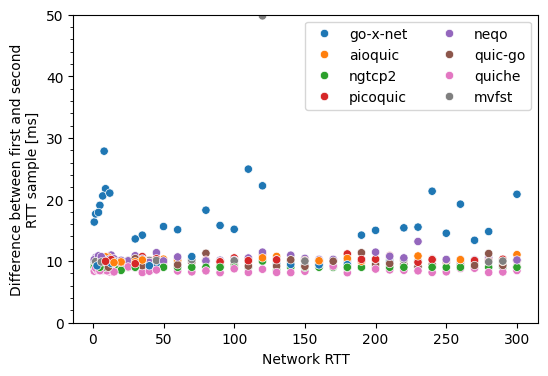

In [6]:
fig, ax = vh.fig_ax(figsize=(6, 4))

sns.scatterplot(
    pagg2.filter(pl.col("scenario") == "goodput", pl.col("server_group") == "WFC"),
    x="rtt",
    y="diff",
    hue="client",
)

ax.legend(ncol=2)
ax.set(ylabel="Difference between first and second\nRTT sample [ms]")
ax.set(xlabel="Network RTT")
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
ax.set(ylim=(0, 50))
plt.show()

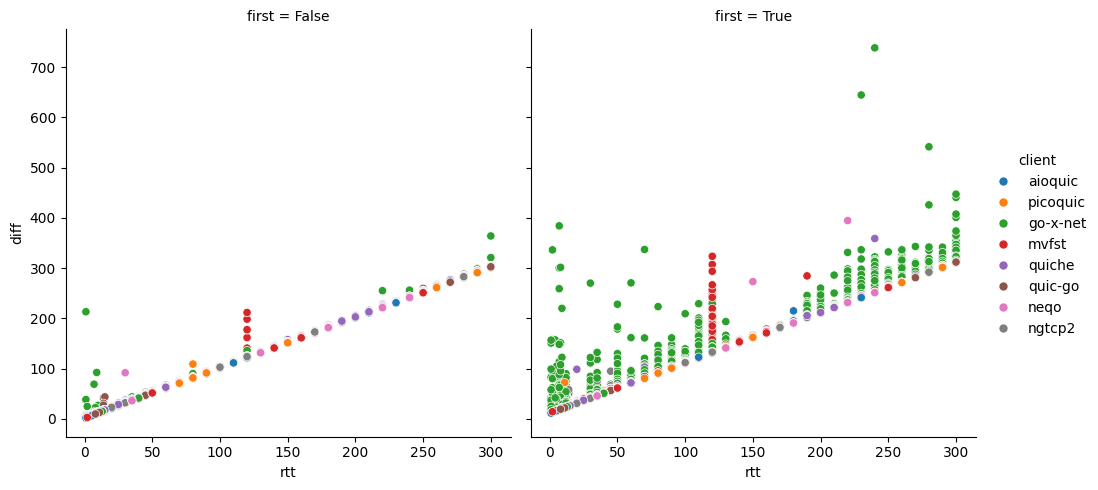

In [7]:
sns.relplot(
    df.filter(pl.col("scenario") == "goodput", pl.col("server_group") == "WFC"),
    x="rtt",
    y="diff",
    hue="client",
    col="first",
)